# Crashlytics

In [67]:
try:
    import pyspark
except ModuleNotFoundError:
    !pip3 install pyspark
    import pyspark
try:
    import pandas as pd
except ModuleNotFoundError:
    !pip3 install pandas
    import pandas as pd
    import csv
try:
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    !pip3 install matplotlib
    import matplotlib.pyplot as plt

In [68]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField, StructType, StringType, LongType, IntegerType, FloatType
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, IndexToString, PCA, StandardScaler, Tokenizer, Word2Vec
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator


In [36]:
#May need to install java for this to work
ss=SparkSession.builder.appName("crashlytics").getOrCreate()

In [37]:
raw_df = ss.read.csv("reduced_crash_data.csv", header=True, inferSchema=True)

In [94]:
raw_df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: string (nullable = true)
 |-- End_Lng: string (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- V

10000

## Imbalance in Data

Crash severity of 2 or 3 is much more common than any other severity ranking, and crash durations (duration of impact on traffic) are recorded as 30 minutes the majority of the time. This shows that the data is imbalanced, which we will have to consider when building our classifier.

In [89]:
severityCount = raw_df.groupBy(F.col("Severity")).count()
severityCount.show()

timeDf = raw_df.withColumn("Duration", (F.col("End_Time").cast("long") - F.col("Start_Time").cast("long"))/60)
time_count = timeDf.groupBy(F.col("Duration")).count()
time_count.orderBy(F.col("count"), ascending=False).show()

timeDf.select(F.col("Duration"), F.col("Severity")).show()
extremeSeverities = timeDf.filter(F.col("Severity") != 3).filter(F.col("Severity") != 2)
extremeSeverities.show()

+--------+-----+
|Severity|count|
+--------+-----+
|       1|    6|
|       3| 3941|
|       4|    6|
|       2| 6047|
+--------+-----+

+------------------+-----+
|          Duration|count|
+------------------+-----+
|              30.0| 2302|
|              75.0|  752|
|              45.0|  739|
|              60.0|  519|
|              90.0|  213|
|29.666666666666668|  161|
|29.716666666666665|  158|
|              29.7|  153|
|             29.65|  151|
|29.683333333333334|  138|
|29.733333333333334|  134|
|29.616666666666667|  128|
|29.633333333333333|  124|
|29.766666666666666|  124|
|             29.75|  118|
|              29.8|  115|
|29.783333333333335|  113|
|              29.6|  110|
|29.583333333333332|  107|
|29.566666666666666|  104|
+------------------+-----+
only showing top 20 rows

+--------+--------+
|Duration|Severity|
+--------+--------+
|   314.0|       3|
|    30.0|       2|
|    30.0|       2|
|    30.0|       3|
|    30.0|       2|
|    30.0|       3|
|    30.0

## Clean data

The classifiers we plan to build cannot handle columns whose values are strings or "categorical" integers like Zipcode. So, we need to do something with them. 
 - For string columns describing categorical data (State, Daytime) we can turn them into indices. 
 - For string columns whose values we do not expect to be relevant to determining crash severity such as timezone, we can drop them from our dataset. 
 - For string columns that we cannot turn into indices but whose information may still be relevant, specifically weather and description, we can use Word2Vec, a neural-network based machine learning model that can turn strings to vectors while still retaining some semantic information.

After doing that processing, we still need to deal with records which have null values. For columns which have an obvious "neutral" stand-in value for null, we will replace all null values with that stand-in value. For columns that do not have an obvious stand-in value, we will have to drop those columns from the table to avoid drastically reducing the total record count.

### Convert categorical strings into indicees

In [90]:
labelIndexer = StringIndexer(inputCols = ["State", "Sunrise_Sunset"], outputCols = ["StateId", "DaytimeId"]).fit(raw_df)
indexedDf = labelIndexer.transform(timeDf)
#transformed_data.show(1)

### Drop irrelevant columns

In [91]:
indexAndTrimmedDf = indexedDf.drop("ID", "Airport_Code", "Zipcode", "Source", "Start_Time", "End_Time", "End_Lat", "End_Lng", "City", "County", "Zipcode", "Country", "Timezone", \
                         "Weather_Timestamp", "Wind_Direction", "Civil_Twilight", "Nautical_Twilight", "Astronomical_Twilight", "Turning_Loop", "State", "Street", "Sunrise_Sunset")


### Convert description and weather into vectors

In [101]:
tokenizer_desc = Tokenizer(inputCol="Description", outputCol="desc_words")
tokenizedDescDf = tokenizer_desc.transform(indexAndTrimmedDf)
word2Vec_desc = Word2Vec(vectorSize=30, minCount=5, inputCol="desc_words", outputCol="desc_word2vec")
model_desc = word2Vec_desc.fit(tokenizedDescDf)
vectorizedDescriptionDf = model_desc.transform(tokenizedDescDf)

tokenizer_weather = Tokenizer(inputCol="Weather_Condition", outputCol="weather_words")
vectorizedDescriptionDf = vectorizedDescriptionDf.fillna({"Weather_Condition": ""})
tokenizedWeatherDf = tokenizer_weather.transform(vectorizedDescriptionDf)
word2Vec_weather = Word2Vec(vectorSize=3, minCount=1, inputCol="weather_words", outputCol="weather_word2vec")
model_weather = word2Vec_weather.fit(tokenizedWeatherDf)
vectorizedWeatherDf = model_weather.transform(tokenizedWeatherDf)

#wordVecData_weather.select("Description", "desc_word2vec", "Weather_Condition", "weather_word2vec").show(420,truncate=False)

cleaned_df = vectorizedWeatherDf.drop("Description", "Weather_Condition", "desc_words", "weather_words")


### Handle null values

In [114]:
cleaned_df = cleaned_df.fillna({"Wind_Chill(F)": 0, "Precipitation(in)": 0, "Wind_Speed(mph)": 0})
cleaned_df.show(1000)

+--------+-----------------+-------------------+------------+--------------+-------------+-----------+------------+--------------+---------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------------+-------+---------+--------------------+--------------------+
|Severity|        Start_Lat|          Start_Lng|Distance(mi)|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|Amenity| Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|          Duration|StateId|DaytimeId|       desc_word2vec|    weather_word2vec|
+--------+-----------------+-------------------+------------+--------------+-------------+-----------+------------+--------------+---------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+---------

## Vectorize our feature columns for use in K-Means clustering, PCA, and training our classifier(s). 

The rest of the processing we do on our data prefers our table be condensed into a single vectorized column, so we do that here.

In [106]:
column_names = cleaned_df.columns
#Lots of columns can have null values so we ignore them when generating out vectorized column
print(cleaned_df.count())
assembler = VectorAssembler(inputCols=column_names, outputCol="features", handleInvalid="skip")
assembled_data = assembler.transform(cleaned_df)
print(assembled_data.count())

10000
9836


## K-Means Clustering

This data has a large number of features, so we will perform K-Means Clustering to see if we can find some patterns in our data and PCA to better understand which features of our dataset affect crash severity.

In [76]:
# Lets define a KMeans fit function since we'll be calling this multiple times
def fit_kmeans(df_input,num_cluster_centers=3):
  kmeans = KMeans().setK(num_cluster_centers).setSeed(1)
  
  model = kmeans.fit(df_input)
  
  clustered_data = model.transform(df_input)

  evaluator = ClusteringEvaluator()
  silhouette_score = evaluator.evaluate(clustered_data)

  wcss = model.summary.trainingCost
  
  return clustered_data, silhouette_score, wcss

In [77]:
# Define a function to perform visualization
def visualize_clusters_2D(clustered_data, feature_1, feature_2,  num_cluster_centers=3):
  pandas_df = clustered_data.select(feature_1, feature_2, "prediction").toPandas()
  
  cluster_assignments = pandas_df["prediction"]
  
  feature1 = pandas_df[feature_1]
  feature2 = pandas_df[feature_2]
  
  for cluster_id in range(num_cluster_centers):
      cluster_data = pandas_df[pandas_df["prediction"] == cluster_id]
      plt.scatter(cluster_data[feature_1], cluster_data[feature_2], label=f'Cluster {cluster_id}')
  
  plt.xlabel(feature_1)
  plt.ylabel(feature_2)
  plt.title("K-Means Clustering")
  
  plt.legend()
  
  plt.show()

In [78]:
k_values = range(2, 20)  # Example: Try K from 2 to 10

silhouette_scores = []
wcss_scores = []

for k in k_values:
  clustered_data, silhouette_score, wcss = fit_kmeans(assembled_data,num_cluster_centers=k)
  silhouette_scores.append(silhouette_score)
  wcss_scores.append(wcss)

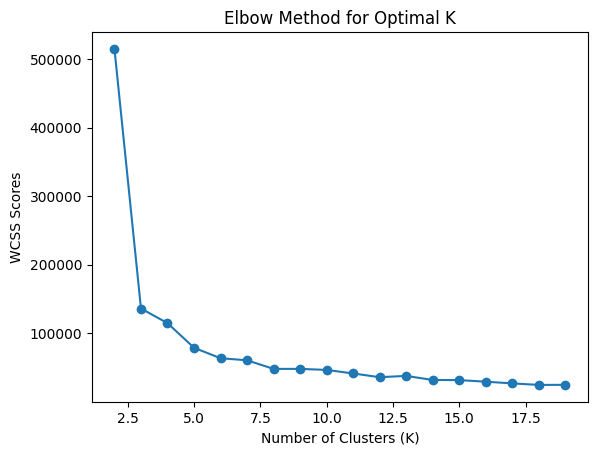

In [79]:
plt.plot(k_values, wcss_scores, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS Scores")
plt.show()

## Result of K-Means
The data does not reveal an obvious candidate for an optimal number of clusters, but 9 clusters seems reasonable.

## PCA

This data has a large number of features, so we will perform PCA to better understand which features of our dataset affect crash severity.

Explained Variance:  0.8383376590065111


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (30,) and arg 1 with shape (59,).

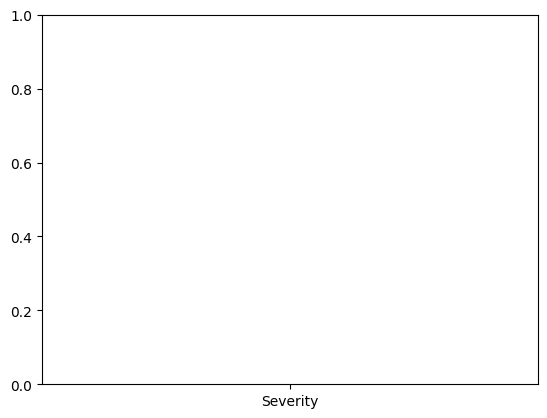

In [84]:
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(assembled_data)
scaled_data = scaler_model.transform(assembled_data)
original_feature_names = scaled_data.columns

pca = PCA(k=16, inputCol="scaled_features", outputCol="pcaFeatures")
model = pca.fit(scaled_data)
result = model.transform(scaled_data)

explained_variance = model.explainedVariance
print("Explained Variance: ", sum(explained_variance))
#eigenvalues = model.explainedVariance.values
#plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o')
#plt.xlabel('Principal Components')
#plt.ylabel('Explained Variance')
#plt.show()

loadings = model.pc.toArray()

first_pc_loadings = loadings[:, 0]
top_contributing_features = [feature_name for feature_name, loading in zip(original_feature_names, first_pc_loadings)]

plt.bar(original_feature_names, first_pc_loadings)
plt.xlabel('Original Features')
plt.ylabel('Loadings')
plt.title('Loadings for the First Principal Component')
plt.show()

In [14]:
def fit_kmeans_column(df_input,column_name='pcaFeatures',num_cluster_centers=3):
  kmeans = KMeans(featuresCol=column_name).setK(num_cluster_centers).setSeed(1)
  
  model = kmeans.fit(df_input)
  
  clustered_data = model.transform(df_input)

  evaluator = ClusteringEvaluator()
  silhouette_score = evaluator.evaluate(clustered_data)

  wcss = model.summary.trainingCost
  
  cluster_sizes = clustered_data.groupBy("prediction").count()
  cluster_sizes.show()
  
  return clustered_data, silhouette_score, wcss

In [15]:
num_centers = 3
clustered_data, silhouette, wcss = fit_kmeans_column(result,column_name='pcaFeatures',num_cluster_centers=num_centers)

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   48|
|         2|   17|
|         0|   17|
+----------+-----+



In [16]:
silhouette_scores_pca = []
wcss_scores_pca = []

for k in k_values:
  clustered_data, silhouette_score, wcss = fit_kmeans_column(result,column_name="pcaFeatures",num_cluster_centers=k)
  silhouette_scores_pca.append(silhouette_score)
  wcss_scores_pca.append(wcss)

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   59|
|         0|   23|
+----------+-----+

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   48|
|         2|   17|
|         0|   17|
+----------+-----+

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   39|
|         3|   15|
|         2|    1|
|         0|   27|
+----------+-----+

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   34|
|         3|   13|
|         4|    1|
|         2|   22|
|         0|   12|
+----------+-----+

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   27|
|         3|   12|
|         5|   16|
|         4|   14|
|         2|    7|
|         0|    6|
+----------+-----+

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   31|
|         6|    6|
|         3|    9|
|         5|   14|
|         4|    7|
|         2|    1|
|         0|   14|
+----------+-----+

+----------+-----+
|predi

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   37|
|         6|   14|
|         3|    1|
|         5|    1|
|         9|    4|
|         4|    2|
|         8|    2|
|         7|   15|
|         2|    1|
|         0|    5|
+----------+-----+

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   20|
|         6|   10|
|         3|    3|
|         5|    1|
|         9|    5|
|         4|   11|
|         8|    2|
|         7|    5|
|        10|   22|
|         2|    1|
|         0|    2|
+----------+-----+

+----------+-----+
|prediction|count|
+----------+-----+
|         1|    8|
|         6|    1|
|         3|    3|
|         5|   27|
|         9|    4|
|         4|    7|
|         8|    4|
|         7|    2|
|        10|    6|
|        11|   17|
|         2|    2|
|         0|    1|
+----------+-----+

+----------+-----+
|prediction|count|
+----------+-----+
|        12|    7|
|         1|   10|
|         6|    1|
|         3|    1|
|        

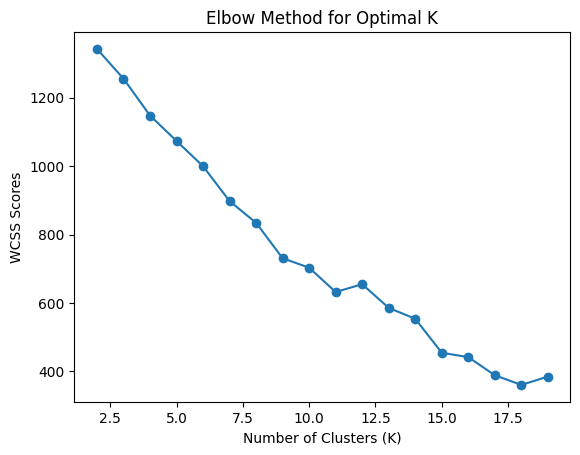

In [17]:
plt.plot(k_values, wcss_scores_pca, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS Scores")
plt.show()

## Decision Tree Classifier

In [18]:
column_names = cleaned_df.drop("Severity", "StreetId", "StateId").columns
#Lots of columns can have null values so we ignore them when generating out vectorized column
vector = VectorAssembler(inputCols=column_names, outputCol="features", handleInvalid="skip")
vectorized_data = vector.transform(cleaned_df)
vectorized_data.show()

+--------+---------+------------------+------------+--------------+-------------+-----------+------------+--------------+---------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+-------+--------+----------+---------+--------------------+
|Severity|Start_Lat|         Start_Lng|Distance(mi)|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|Amenity| Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|StateId|StreetId|Weather_Id|DaytimeId|            features|
+--------+---------+------------------+------------+--------------+-------------+-----------+------------+--------------+---------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+-------+--------+----------+---------+--------------------+
|       3| 40.10

In [19]:
trainingData, validationData, testData = vectorized_data.randomSplit([0.6, 0.2, 0.2], seed=42)

dt=DecisionTreeClassifier(featuresCol="features", labelCol="Severity", maxDepth=6, minInstancesPerNode=2, maxBins=32)
dt_model = dt.fit(trainingData)
test_prediction = dt_model.transform(testData)
test_prediction.show(10)

+--------+---------+------------------+------------+--------------+-------------+-----------+------------+--------------+---------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+-------+--------+----------+---------+--------------------+------------------+--------------------+----------+
|Severity|Start_Lat|         Start_Lng|Distance(mi)|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|Amenity| Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|StateId|StreetId|Weather_Id|DaytimeId|            features|     rawPrediction|         probability|prediction|
+--------+---------+------------------+------------+--------------+-------------+-----------+------------+--------------+---------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+-----

## Classification with XGBoost